In [82]:
import os
import json
import matplotlib.pyplot as plt

In [83]:
# Collect organizations and their co-occurences

orgs = []
texts = []
years = []
occurences = []

dir = 'data/biomass/'
files = os.listdir(dir)

for index, filename in enumerate(files):

    print(index, end=' ')
    
    f = open(dir + filename)
    r = f.read()
    parsed = json.loads(r)
    
    # Set tags and remove excessive values

    try:
        # Set tags
        tags = parsed[0]['story_tags']
        
        # Set max
        if len(tags) > 1000: continue
        
        # Set year
        year = int(parsed[0]['publish_date'].split(' ')[0].split('-')[0])
    
    except:
        continue


    # Collect organizations' names
    
    _names = []

    for tag in tags:
        if (tag['tag_set'] == 'cliff_organizations'):
            
            label = tag['tag']
            label = label.replace('.', '')
            
            if label.startswith('U.S. '): label = label.replace('U.S. ', '')
            if label.startswith('US '): label = label.replace('US ', '')
            
            if label == 'EU': label = 'European Union'
            # if label == 'E.U.': label = 'European Union'
            if label == 'IEA': label = 'International Energy Agency'
            if label == 'Exxon': label = 'ExxonMobil'
            if label == 'Exxon Mobil': label = 'ExxonMobil'
            if label == 'ExonnMobil': label = 'ExxonMobil'
            if label == 'US Energy Information Administration': label = 'Energy Information Administration'
            if label == 'Massachusetts Institute of Technology': label = 'MIT'
            # if label == 'U.N.': label = 'United Nations'
            if label == 'UN': label = 'United Nations'
            if label == 'EDF': label = 'Environmental Defense Fund'
            if label == 'Interior': label = 'Interior Department'
            if label == 'EIA': label = 'Energy Information Administration'
            if label == 'AP': label = 'Associated Press'
            if label == 'NOAA': label = 'National Oceanic and Atmospheric Administration'
            if label == 'US Forest Service': label = 'Forest Service'
            if label == 'US Department of Energy': label = 'Energy Department'
            if label == 'Energy Department': label = 'Department of Energy'
            if label == 'DOE': label = 'Department of Energy'
            if label == 'Energy': label = 'Department of Energy'
            if label == 'Agriculture': label = 'Department of Agriculture'
            if label == 'GE': label = 'General Electric'
            if label == 'Stanford': label = 'Stanford University'
            if label == 'NRDC': label = 'Natural Resources Defense Council'
            if label == 'EPA': label = 'Environmental Protection Agency'
            if label == 'Harvard': label = 'Harvard University'
            if label == 'house': label = 'House'
            if label == 'FDA': label = 'Food and Drug Administration'
            if label == 'GOP': label = 'Republican Party'
            if label == 'PG&E': label = 'Pacific Gas & Electric Co'
            if label == 'Xcel': label = 'Xcel Energy'
            if label == 'Penn State': label = 'Pennsylvania State University'
            if label == 'El Nino': label = 'El Niño'
            if label == 'SEC': label = 'Securities and Exchange Commission'
            if label == 'Sierra': label = 'Sierra Club'
            if label == 'PUC': label = 'Public Utilities Commission'

            stoplist = {'Elon Musk', 'Trump', 'CCS', 'green energy', 'clean energy'}
            
            if label not in stoplist:
                _names.append(label)

    # Collect by name

    # x -> years
    # y -> occurencies

    _years = {
        2011: 0,
        2012: 0,
        2013: 0,
        2014: 0,
        2015: 0,
        2016: 0,
        2017: 0,
        2018: 0,
        2019: 0,
        2020: 0
    }

    for n in _names:
        if n in orgs:
            
            index = orgs.index(n)
            texts[index] = texts[index] + _names
            occurences[index] += 1
            
            if year in years[index]:
                years[index][year] += 1
            else:
                years[index][year] = 1
                
        else:
            orgs.append(n)
            texts.append(_names)
            occurences.append(1)
            
            years.append(_years)
            years[index][year] = 1


# Clean less citates organizations

for index, occurrence in reversed(list(enumerate(occurences))):

    min = 40

    if occurrence < min:
        orgs.pop(index)
        texts.pop(index)
        years.pop(index)
        occurences.pop(index)
    # else:
        # print()
        # print(index, occurrence, orgs[index])
        # print()

# order years by key in an array of tuples

for index, y in enumerate(years):
    sortedDict = dict( sorted(y.items(), key=lambda x: x[0]) )
    _temp = {}
    for k,v in sortedDict.items():
        _temp[k] = v
    years[index] = _temp

print(len(orgs), len(texts), len(years), len(occurences))

# print(occurences[0])
# print(years[0][:, 0])



119 23120 23121 23122 23123 23124 23125 23126 23127 23128 23129 23130 23131 23132 23133 23134 23135 23136 23137 23138 23139 23140 23141 23142 23143 23144 23145 23146 23147 23148 23149 23150 23151 23152 23153 23154 23155 23156 23157 23158 23159 23160 23161 23162 23163 23164 23165 23166 23167 23168 23169 23170 23171 23172 23173 23174 23175 23176 23177 23178 23179 23180 23181 23182 23183 23184 23185 23186 23187 23188 23189 23190 23191 23192 23193 23194 23195 23196 23197 23198 23199 23200 23201 23202 23203 23204 23205 23206 23207 23208 23209 23210 23211 23212 23213 23214 23215 23216 23217 23218 23219 23220 23221 23222 23223 23224 23225 23226 23227 23228 23229 23230 23231 23232 23233 23234 23235 23236 23237 23238 23239 23240 23241 23242 23243 23244 23245 23246 23247 23248 23249 23250 23251 23252 23253 23254 23255 23256 23257 23258 23259 23260 23261 23262 23263 23264 23265 23266 23267 23268 23269 23270 23271 23272 23273 23274 23275 23276 23277 23278 23279 23280 23281 23282 23283 23284 23285 

In [84]:
# Total linear regression

import numpy as np
from sklearn.linear_model import LinearRegression

total_years = {}

for year in years:
    # print(year)
    for k,v in year.items():
        # print(k, v)
        if k in total_years:
            total_years[k] += v
        else:
            total_years[k] = v

y = list(year.values())
x = list(year.keys())
x = np.array(x).reshape((-1, 1))

model = LinearRegression().fit(x, y)
slope = model.coef_
total_slope = slope[0]
# score = model.score(x, y)

total_years, total_slope


({2011: 1983,
  2012: 1424,
  2013: 2122,
  2014: 1803,
  2015: 2995,
  2016: 2447,
  2017: 2757,
  2018: 3477,
  2019: 4028,
  2020: 5360},
 0.9454545454545452)

In [85]:
# Linear regression

import matplotlib.colors

slopes = []
colors = []

_min = 0
_max = 0


# Slope

for year in years:

    y = list(year.values())
    x = list(year.keys())
    x = np.array(x).reshape((-1, 1))
    
    model = LinearRegression().fit(x, y)
    slope = model.coef_
    # slope = slope[0] - total_slope
    slope = slope[0]
    score = model.score(x, y)
    slopes.append(slope)

    if slope > _max: _max = slope
    if slope < _min: _min = slope

    # print()
    # print(list(year.keys()), y)
    # print('slope', slope, 'score', score)

print('min', _min, 'max', _max)

# Colors

cmap = plt.cm.RdYlBu_r
cmap = plt.cm.coolwarm
# norm = matplotlib.colors.Normalize(vmin=_min, vmax=_max)
norm = matplotlib.colors.DivergingNorm(vmin=_min, vcenter=0, vmax=_max)
# norm = matplotlib.colors.DivergingNorm(vmin=-10, vcenter=0, vmax=10)

for slope in slopes:
    color = cmap(norm(slope))
    colors.append(color)


min -3.9333333333333336 max 8.630303030303027


In [86]:
# Term Frequency Matrix

import textacy

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(texts, tf_type="linear", idf_type="smooth")

 * creating mesh with size 58 58
 * filling mesh


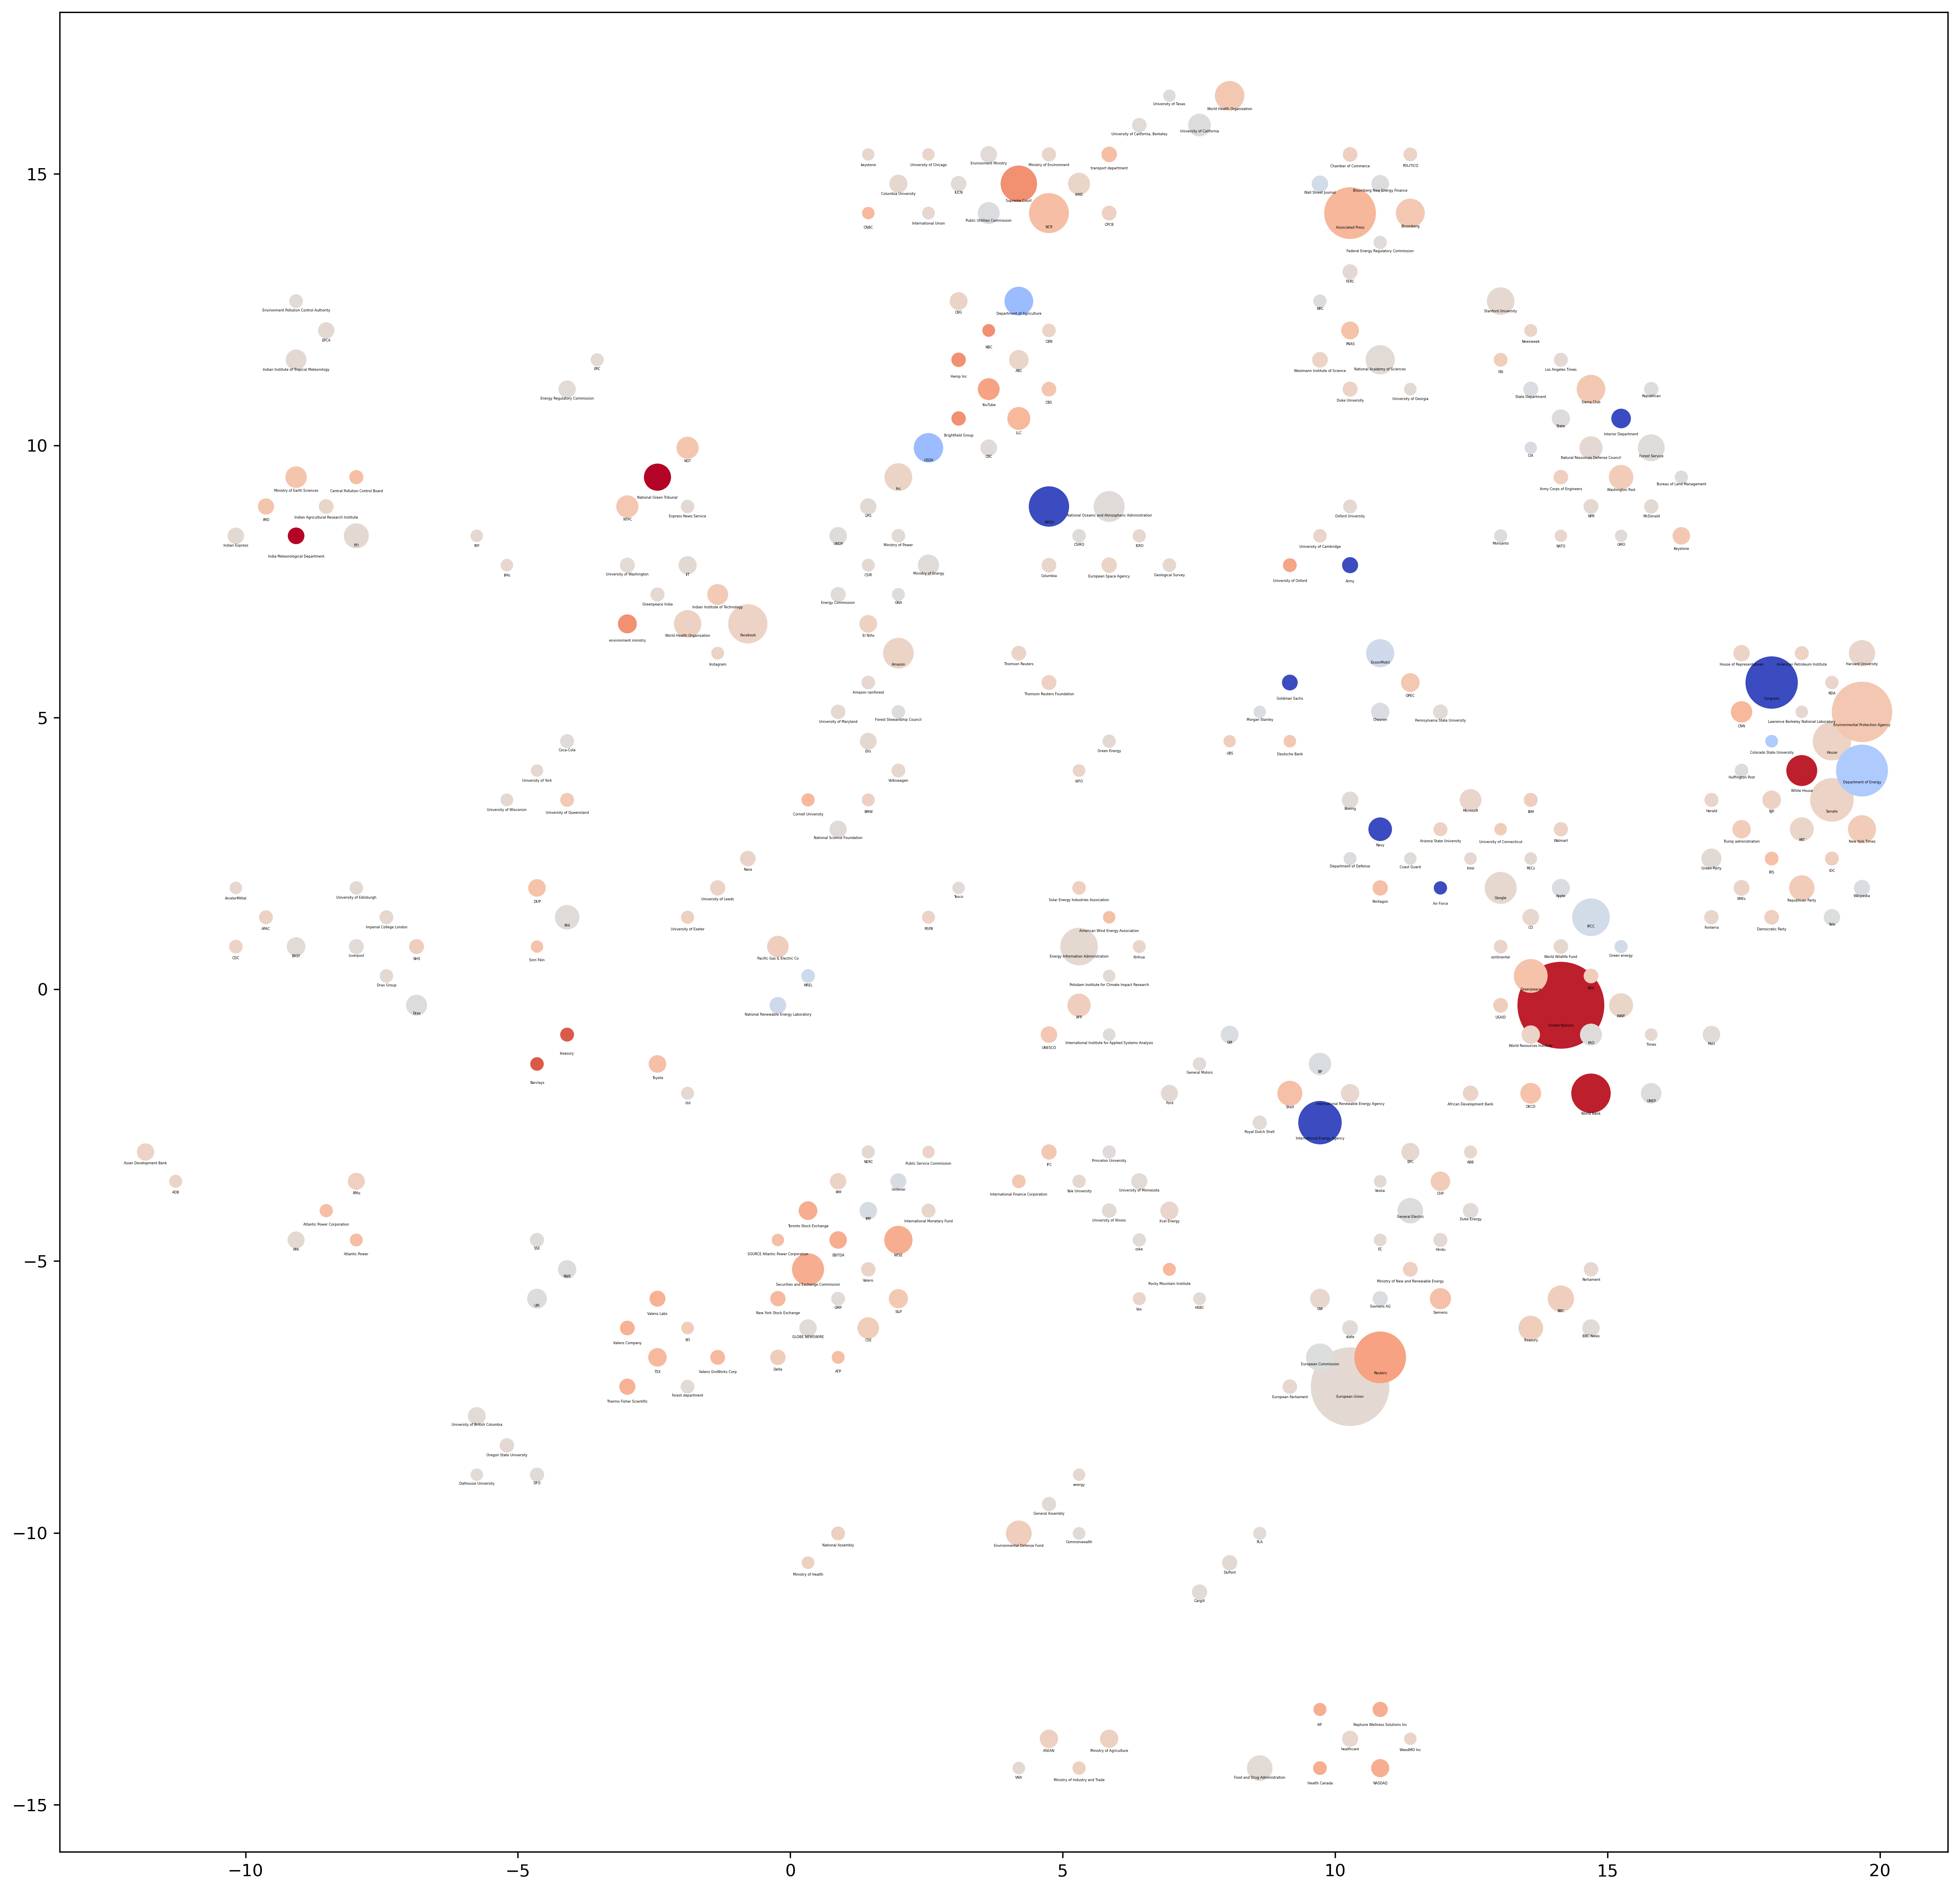

In [87]:
# UMAP

import umap
import math
import matplotlib.pyplot as plt
from pointgrid import align_points_to_grid


reducer = umap.UMAP(n_components=2, n_neighbors=2, min_dist=0.01, metric='cosine')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

for index, s in enumerate(slopes):
    slopes[index] = abs(s)*40

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=occurences, c=colors)
# plt.scatter(x, y, s=slopes, c=colors)

for i, txt in enumerate(orgs):
    text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(slopes[i]/math.pi)/40 - .15), ha='center', va='bottom')
    text.set_fontsize(2)

plt.savefig('/Users/dario/Desktop/download.png')
plt.savefig('download.png')